# 1. Setup & Instalasi

In [ ]:
!pip install roboflow
!pip install albumentations opencv-python-headless
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import random
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import albumentations as A
from tqdm import tqdm

# 2. Download Dataset dari Roboflow

In [ ]:

from roboflow import Roboflow
rf = Roboflow(api_key="Vj9OCSaGYO75OWuZjpUW")
project = rf.workspace("ta-zwiyos").project("helmonzy")
version = project.version(5)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to helmonzy-5 in yolov8:: 100%|██████████| 7242/7242 [00:01<00:00, 5444.78it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 3. Visualisasi dan Eksplorasi Dataset

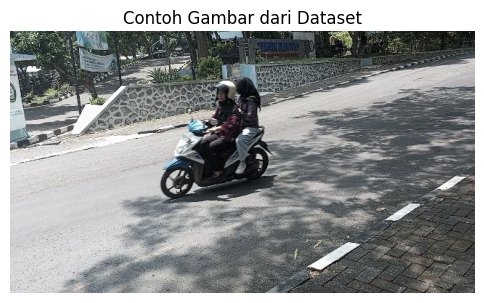

In [ ]:
img_paths = glob.glob("helmonzy-5/train/images/*.jpg")
sample = random.choice(img_paths)

img = cv2.imread(sample)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Contoh Gambar dari Dataset")
plt.axis("off")
plt.show()

In [ ]:
# Fungsi bantu untuk menggambar bounding box dari label YOLO
def draw_bbox_yolo(image_path, label_path, class_names, color=(0, 255, 0)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls_id, x_center, y_center, bw, bh = map(float, line.strip().split())
                x1 = int((x_center - bw/2) * w)
                y1 = int((y_center - bh/2) * h)
                x2 = int((x_center + bw/2) * w)
                y2 = int((y_center + bh/2) * h)

                cls_name = class_names[int(cls_id)]
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, cls_name, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return image

In [ ]:
def visualize_multiple_yolo_images(image_dir, label_dir, class_names, num_images=10):
    import matplotlib.pyplot as plt

    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(15, 10))

    for idx, img_file in enumerate(selected_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

        image = draw_bbox_yolo(img_path, lbl_path, class_names)

        plt.subplot(2, 5, idx+1)  # 2 baris x 5 kolom
        plt.imshow(image)
        plt.title(img_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


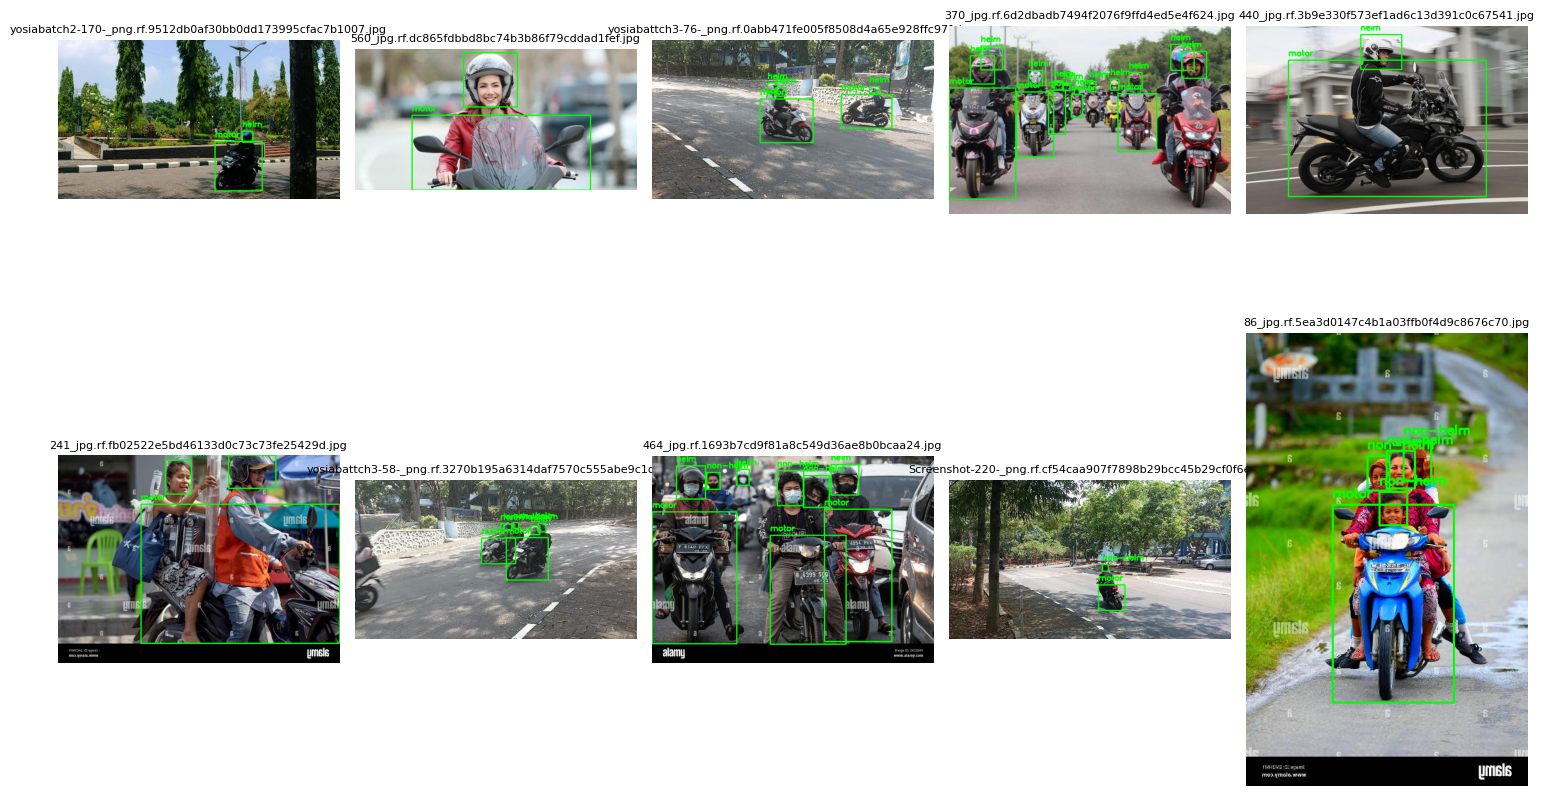

In [ ]:
class_names = ['helm', 'motor', 'non-helm']

visualize_multiple_yolo_images(
    image_dir="/content/helmonzy-5/train/images",
    label_dir="/content/helmonzy-5/train/labels",
    class_names=class_names,
    num_images=10
)

## 3.1. Hitung Total Gambar per Split (Train/Val/Test)

In [ ]:
base_path = "/content/helmonzy-5"
class_names = ['helm', 'motor', 'non-helm']
num_classes = len(class_names)

In [ ]:
def count_images_by_split(base_path="/content/helmonzy-5"):
    for split in ['train', 'valid', 'test']:
        img_dir = os.path.join(base_path, split, "images")
        num_images = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
        print(f"{split.capitalize()} Images: {num_images}")

In [ ]:
count_images_by_split(base_path)

Train Images: 3164
Valid Images: 302
Test Images: 149


## 3.2 Distribusi Jumlah Kelas (helm, motor, non-helm)

In [ ]:
def count_class_distribution(label_dir, class_names):
    counts = Counter()
    for lbl_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, lbl_file), "r") as f:
            for line in f:
                cls_id = int(line.split()[0])
                counts[cls_id] += 1
    for i, name in enumerate(class_names):
        print(f"{name}: {counts[i]} label(s)")

In [ ]:
count_class_distribution(f"{base_path}/train/labels", class_names)

helm: 4051 label(s)
motor: 4501 label(s)
non-helm: 2736 label(s)


## 3.3. Jumlah Bounding Box per Gambar

In [ ]:
def count_objects_per_image(label_dir):
    obj_counts = []
    for lbl_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, lbl_file), "r") as f:
            obj_counts.append(len(f.readlines()))
    plt.hist(obj_counts, bins=range(1, max(obj_counts)+2))
    plt.title("Distribusi Jumlah Bounding Box per Gambar")
    plt.xlabel("Jumlah objek")
    plt.ylabel("Jumlah gambar")
    plt.show()

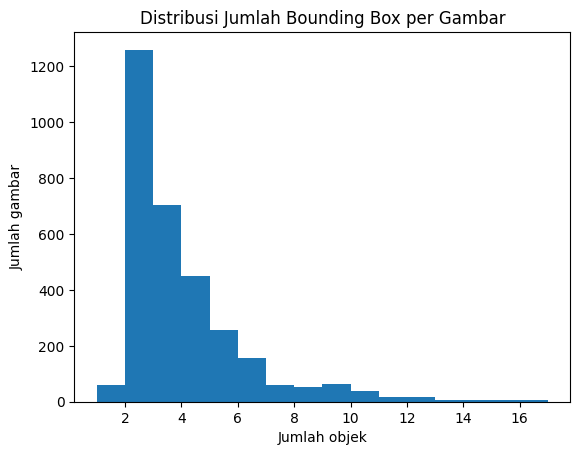

In [ ]:
count_objects_per_image(f"{base_path}/train/labels")

## 3.4. Distribusi Ukuran Bounding Box (area relatif)

In [ ]:
def bbox_size_distribution(label_dir):
    sizes = []
    for lbl_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, lbl_file), "r") as f:
            for line in f:
                _, _, _, w, h = map(float, line.strip().split())
                area = w * h
                sizes.append(area)
    plt.hist(sizes, bins=30)
    plt.title("Distribusi Luas Bounding Box (YOLO normalized area)")
    plt.xlabel("Luas (w*h)")
    plt.ylabel("Jumlah bounding box")
    plt.show()

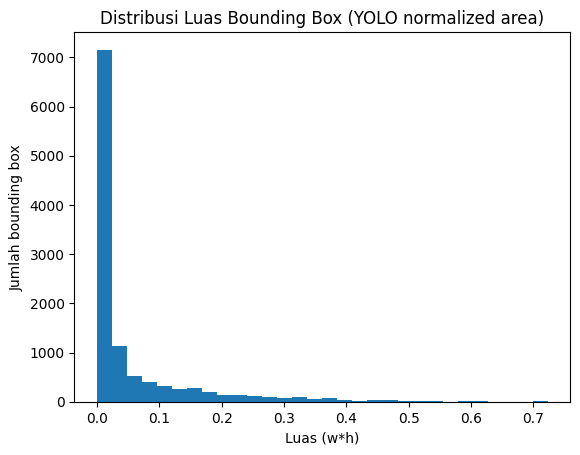

In [ ]:
bbox_size_distribution(f"{base_path}/train/labels")

## 3.5. Periksa Label Tidak Valid / Gambar Tanpa Label

In [ ]:
def check_missing_or_invalid_labels(image_dir, label_dir, num_classes):
    image_files = set([f.rsplit(".", 1)[0] for f in os.listdir(image_dir)])
    label_files = set([f.rsplit(".", 1)[0] for f in os.listdir(label_dir)])

    no_label = image_files - label_files
    print(f"📛 Gambar tanpa label: {len(no_label)}")

    # Cek class_id out-of-range
    invalid = 0
    for lbl_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, lbl_file), "r") as f:
            for line in f:
                cls_id = int(line.split()[0])
                if cls_id >= num_classes:
                    invalid += 1
    print(f"⚠️ Label dengan class_id invalid (>={num_classes}): {invalid}")

In [ ]:
check_missing_or_invalid_labels(f"{base_path}/train/images", f"{base_path}/train/labels", num_classes)

📛 Gambar tanpa label: 0
⚠️ Label dengan class_id invalid (>=3): 0


# 4. Data Augmentation

In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.


In [ ]:
image_dir = "/content/helmonzy-5/train/images"
label_dir = "/content/helmonzy-5/train/labels"

aug_image_dir = image_dir  # Save to same train folder
aug_label_dir = label_dir


In [ ]:
def load_yolo_label(label_path):
    with open(label_path, "r") as f:
        lines = f.read().strip().split("\n")
    boxes = []
    class_labels = []
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            cls, x, y, w, h = parts
            boxes.append([float(x), float(y), float(w), float(h)])
            class_labels.append(int(cls))
    return boxes, class_labels

def save_yolo_label(label_path, boxes, class_labels):
    with open(label_path, "w") as f:
        for box, cls in zip(boxes, class_labels):
            line = f"{cls} {' '.join([f'{coord:.6f}' for coord in box])}\n"
            f.write(line)


In [ ]:
augment_count = 3  # How many augmented versions per original image

image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

for img_name in tqdm(image_files, desc="Augmenting"):
    image_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))

    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    boxes, class_labels = load_yolo_label(label_path)

    for i in range(augment_count):
        augmented = transform(image=image, bboxes=boxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_boxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        if len(aug_boxes) == 0:
            continue  # skip if no valid bbox after aug

        aug_img_name = img_name.replace(".jpg", f"_aug{i}.jpg")
        aug_label_name = aug_img_name.replace(".jpg", ".txt")

        cv2.imwrite(os.path.join(aug_image_dir, aug_img_name), aug_img)
        save_yolo_label(os.path.join(aug_label_dir, aug_label_name), aug_boxes, aug_labels)


Augmenting: 100%|██████████| 3164/3164 [00:55<00:00, 56.94it/s]


# 5. Modelling

## YOLOv8 Ultralytics

In [ ]:
!yolo detect train model=yolov8n.pt data=/content/helmonzy-5/data.yaml epochs=100 imgsz=320

100% 6.25M/6.25M [00:00<00:00, 112MB/s]
Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/helmonzy-5/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspect

## Testing Image

In [ ]:
#Jalankan inferensi pada test set:
!yolo detect predict model=runs/detect/train/weights/best.pt source=/content/helmonzy-5/test/images save=True

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/149 /content/helmonzy-5/test/images/103_jpg.rf.0257f2f1c4f5ffc09742441a8dedeed3.jpg: 256x320 1 non-helm, 35.2ms
image 2/149 /content/helmonzy-5/test/images/106_jpg.rf.201753b60797d5a4d0462172af9c15b1.jpg: 256x320 1 helm, 2 motors, 1 non-helm, 6.8ms
image 3/149 /content/helmonzy-5/test/images/107_jpg.rf.e47a634a0447d77309b0565f658d5f43.jpg: 320x256 1 helm, 3 motors, 1 non-helm, 32.7ms
image 4/149 /content/helmonzy-5/test/images/10_jpg.rf.8618056e88e98665903ecdbf12a8af1c.jpg: 256x320 2 helms, 1 motor, 1 non-helm, 6.6ms
image 5/149 /content/helmonzy-5/test/images/114_jpg.rf.1b23491e7dfb325f52ba1a6ac4ce4b0a.jpg: 256x320 1 helm, 2 motors, 4 non-helms, 5.9ms
image 6/149 /content/helmonzy-5/test/images/115_jpg.rf.a10c1fab7d484738f049e7fa1061ba25.jpg: 256x320 2 helms, 2 motors, 2 non-helms, 5.8ms
image 7/149 /content/helmonz

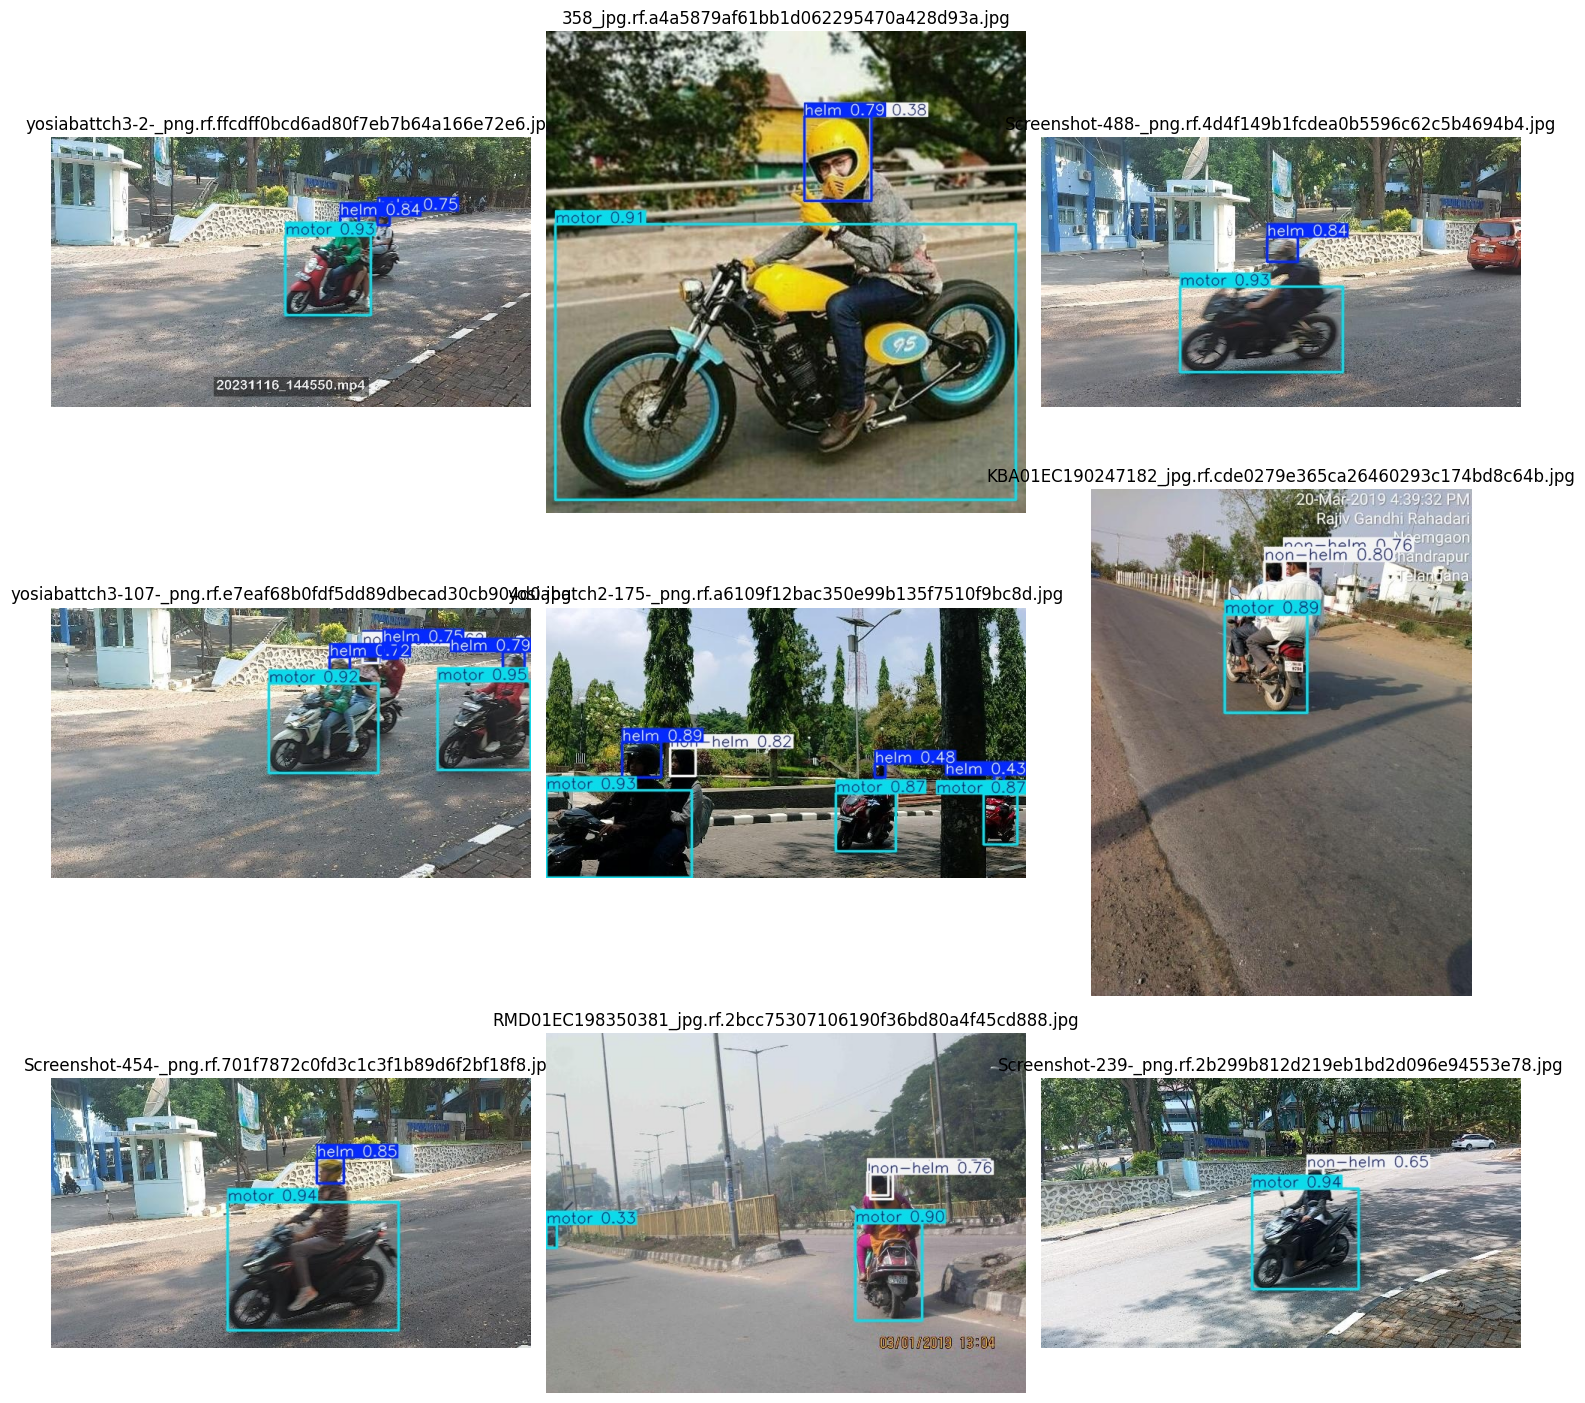

In [ ]:
# Folder hasil prediksi
result_dir = "runs/detect/predict"
files = [f for f in os.listdir(result_dir) if f.endswith(('.jpg', '.png'))][:9]  # ambil 9 gambar

# Plot 3x3
plt.figure(figsize=(15, 15))
for i, file in enumerate(files):
    img = cv2.imread(os.path.join(result_dir, file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Evaluasi Model

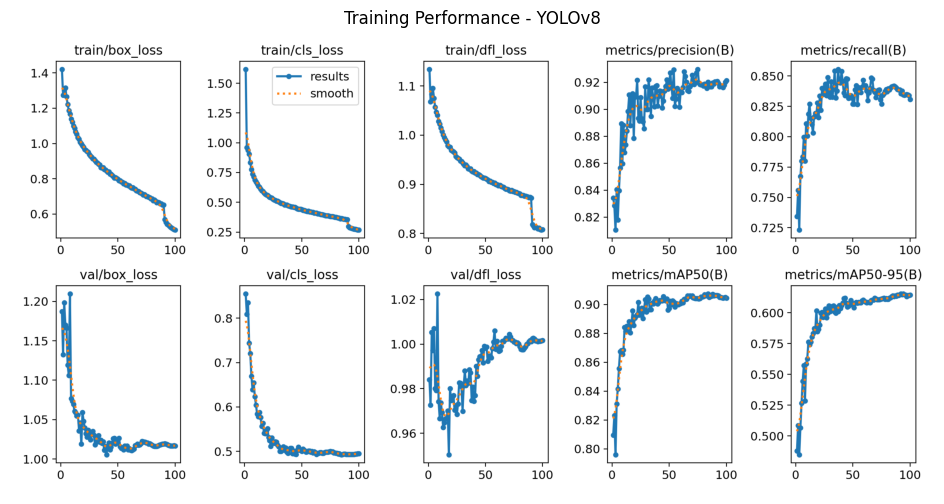

In [ ]:
# Tampilkan grafik training
img_path = "runs/detect/train/results.png"
img = Image.open(img_path)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Training Performance - YOLOv8")
plt.show()

# 7. Save Model

In [ ]:
# jika ingin eksprot ke TFLite
!yolo export model=runs/detect/train/weights/best.pt format=tflite

Ultralytics 8.3.152 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 7, 2100) (5.9 MB)
E0000 00:00:1749491118.058312   48748 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749491118.120376   48748 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0,<1.18.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.56', 'onnxruntime'] not found, attemp

In [ ]:
import shutil

#Simpan Model
# Folder yang akan dikompres
source_folder = 'runs/detect/train'
# Nama file zip yang dihasilkan
zip_filename = 'yolov8_train_results.zip'

# Buat file ZIP dari folder
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', source_folder)

print(f"Folder '{source_folder}' berhasil dikompres menjadi '{zip_filename}'")

Folder 'runs/detect/train' berhasil dikompres menjadi 'yolov8_train_results.zip'
